In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from utils import llava_load_model, llava_process_image, llava_generate
from lens_utils import llava_logit_lens

##### Constants

In [2]:
project_dir = "/home/drdo/vlm-compositionality"

dataset_folder = project_dir+"/data/raw/sugarcrepe",
image_folder = project_dir+"/data/raw/coco/coco_val_2017"
model_name = "llava-hf/llava-1.5-7b-hf"
#image_file = project_dir+"/data/raw/coco_val_2017/000000008690.jpg"
image_file = project_dir+"/data/raw/coco/coco_val_2014/COCO_val2014_000000562150.jpg"

num_patches = 24

##### Load image

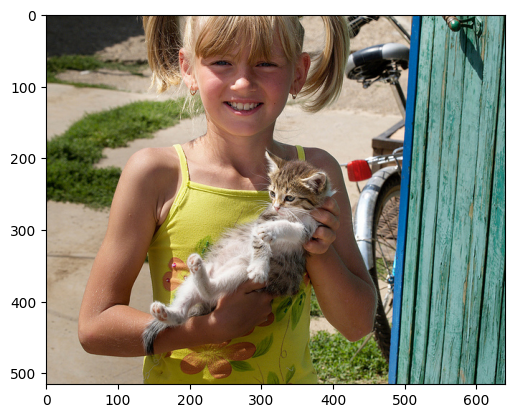

In [3]:
# load image
image = Image.open(image_file).convert("RGB")
plt.imshow(image)

##### Load model

In [4]:
# load model, processor
model, processor = llava_load_model(model_name) #, flash_attention=False, torch_dtype=torch.float32)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

##### Process inputs

In [5]:
# process image and prompt(default)
inputs = llava_process_image(image, processor, device=model.device)

##### Get hidden states

In [6]:
# generate
outputs = llava_generate(inputs, model)

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


##### Get logit lens

In [7]:
# vocab_dim, num_layers, num_tokens
softmax_probs = llava_logit_lens(inputs, model, outputs)

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.84 GiB. GPU 0 has a total capacity of 23.61 GiB of which 2.29 GiB is free. Including non-PyTorch memory, this process has 17.93 GiB memory in use. Of the allocated memory 16.45 GiB is allocated by PyTorch, and 1.02 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

##### Object

In [ ]:
class_ = 'cat'
class_token_indices = processor.tokenizer.encode(class_)[1:]

#### Internal confidence heatmap

In [ ]:
heatmap_data = softmax_probs[class_token_indices].max(axis=0).T
num_image_embeddings = softmax_probs.shape[2]
im = plt.imshow(heatmap_data, aspect=30/num_image_embeddings, cmap='Blues', interpolation='nearest')
plt.title(f"'{class_}' probabilities")
plt.xlabel("LM Layer")
plt.ylabel("Image Embedding Index")
plt.tight_layout()
plt.clim(0, 1)
plt.colorbar()
plt.show()

##### Localization

In [ ]:
def viz_localization(softmax_probs, class_token_indices, image, layer=None):

    img_width, img_height = image.size

    if layer is None:
        softmax_probs = softmax_probs[class_token_indices].max(axis=0).max(axis=0)
    else:
        softmax_probs = softmax_probs[class_token_indices].max(axis=0)[layer]
    segmentation = softmax_probs.reshape(num_patches, num_patches).astype(float)

    # TODO: other interpolation methods apart from Image.BILINEAR
    segmentation_resized = (np.array(Image.fromarray(segmentation).resize((img_width, img_height), Image.BILINEAR)))
    plt.imshow(image)
    plt.imshow(segmentation_resized, cmap='jet', interpolation='bilinear', alpha=.5)
    plt.axis('off')
    # TODO: layer in title
    plt.title(f"'{class_},' localization")
    plt.tight_layout()
    plt.show()

##### Max localization

In [ ]:
viz_localization(softmax_probs, class_token_indices, image)

##### Localization by layer

In [ ]:
viz_localization(softmax_probs, class_token_indices, image, 33)

##### Localization evaluation